# Sentiment Analysis on Musical Instruments Reviews

Author: **Marcin Sikorski**<br>
Date: July, 2023

**Introduction**<br>
Customer ratings and reviews on e-commerce platforms such as Amazon have a substantial influence on the product reputation as they act as drivers for prospective buyers before they decide to make purchases. Amazon gives its customers the option of providing ratings and comments as feedback for its products. While numeric ratings are usefull, it has been observed that the actual sentiment of the customers is better reflected in their comments. Sentiment analysis is a type of text mining useful to uncover customer opinions and understand the general customer sentiment about a product. This type of analysis is used to identify the emotions behind on text. The most common use of sentiment analysis is detecting the polarity of text data, that is, automatically identifying if a tweet, product review (in our case) or support ticket is talking positively, negatively, or neutral about something. Of course, manual work to go through the feedback comments is certainly an overwhelming task, especially on a website with humongous traffic such as Amazon. Sentiment analysis is likewise a quick field that is continually advancing and creating.

This notebook is a natural language processing (NLP) project elaborating the implementation of text mining methods for sentiment analysis. We will demonstrate a few examples of sentiment scoring and predict on overall sentiment - positive, neutral and negative, of customer reviews for musical instruments on Amazon.

**Data source:** [Kaggle](https://www.kaggle.com/datasets/eswarchandt/amazon-music-reviews)

**Notebook Content:**
1. Importing Dataset and Text Cleaning
2. Exploratory Data Analysis
3. Sentiment Analysis<br>
    3a. VADER Sentiment Scoring<br>
    3b. RoBERTa Sentiment Scoring<br>
4. Preprocessing and Splitting Data
5. Model Training and Evaluating
6. Conclusions

### 1. Importing Dataset and Text Cleaning

The dataset is in a ZIP file in JSON format. We will load it, summarize the dataframe by searching for data type and null values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import JSON data from ZIP file and create dataframe
def read_jsonfile():
    import zipfile
    import json
    with zipfile.ZipFile('archive.zip', 'r') as z_file:
        # iterate over file and load into list of dicts
        data = [json.loads(line) for line in z_file.open('Musical_Instruments_5.json', 'r')]
        
        df = pd.DataFrame.from_dict(data)
    return df

df = read_jsonfile()

# display first rows
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


**Data Description**

Content and meaning of each column in the data is as below:
* **reviewerID** - ID of the reviewer
* **asin** - ID of the product
* **reviewerName** - name of the reviewer
* **helpful** - helpfulness rating of the review, e.g. 2/3
* **reviewText** - text of the review
* **overall** - rating of the product
* **summary** - summary or title of the review
* **unixReviewTime** - timestamp of the review in unix format
* **reviewTime** - date and time at which review was submitted

In [2]:
# display data type and count null values for each column
def columns_summary():  
    # empty lists
    col_list = df.columns.to_list()
    dtype_list = []
    null_list = []
    
    for col in df.columns:
        dtype_list.append(df[col].dtype)
        null_list.append(df[col].isnull().sum())
    
    # stack lists into dataframe
    df_sum = pd.DataFrame(list(zip(col_list, dtype_list, null_list)),
                          columns = ['Feature', 'Data type', 'Null values'])
    
    return df_sum.style.hide_index()
    
columns_summary()

Feature,Data type,Null values
reviewerID,object,0
asin,object,0
reviewerName,object,27
helpful,object,0
reviewText,object,0
overall,float64,0
summary,object,0
unixReviewTime,int64,0
reviewTime,object,0


We have null values in the <code>reviewerName</code> column. No steps will we made on this column since it will be useless for further analysis.

A new column will be added to the dataframe containing sentiment reviews based on their overall ranks.

In [3]:
# remove unnecessary columns
def remove_columns():
    for col in ['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 'summary']:
        df.drop(col, axis=1, inplace=True)
        
remove_columns()

# sentiment function
def sentiment(rating):
    if rating['overall'] > 3:
        value = 'positive'
    elif rating['overall'] == 3:
        value = 'neutral'
    elif rating['overall'] == 1 or rating['overall'] == 2:
        value = 'negative'
    else:
        value = -1
    return value

# apply into dataframe
df['sentiment'] = df.apply(sentiment, axis=1)
df.head()

,reviewText,overall,reviewTime,sentiment
0,"Not much to write about here, but it does exac...",5.0,"02 28, 2014",positive
1,The product does exactly as it should and is q...,5.0,"03 16, 2013",positive
2,The primary job of this device is to block the...,5.0,"08 28, 2013",positive
3,Nice windscreen protects my MXL mic and preven...,5.0,"02 14, 2014",positive
4,This pop filter is great. It looks and perform...,5.0,"02 21, 2014",positive


**Text Cleaning**

The most important column for the analysis is the <code>reviewText</code> and needs text cleaning, normalizing, and formatting to make it easier to work on it. We will implement some of these regular expressions operations:
* set lowercase formatting and remove capitalization,
* remove punctuation,
* remove new lines,
* remove links,
* remove text in round or square brackets,
* remove unicode characters,
* remove stopwords.

In [4]:
# apply text operations on reviews
def clean_reviews(review):
    import re
    #nltk.download('stopwords')
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    
    text = review.lower()
    text = re.sub("'", '', text) # to avoid removing contractions in English
    text = re.sub('@[A-Za-z0-9_]+', '', text)
    text = re.sub('#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'http\S+', '', text) # remove HTTPS links
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]', ' ', text) # remove text in brackets
    text = re.sub('[^a-z0-9]', ' ', text) # remove spaces
    text = re.sub('\n', '', text) # remove new lines
    text = re.sub('\w*\d\w*', '', text) # remove numbers contained in words
    text = text.split() # split into a list
    text = [word for word in text if not word in stop_words] # remove stop words
    text = ' '.join(word for word in text)
    
    return text

df['review_new'] = df['reviewText'].apply(lambda x: clean_reviews(x))

# compare reviews
df.loc[:, ['reviewText', 'review_new']].head(10)

,reviewText,review_new
0,"Not much to write about here, but it does exac...",much write exactly supposed filters pop sounds...
1,The product does exactly as it should and is q...,product exactly quite affordable realized doub...
2,The primary job of this device is to block the...,primary job device block breath would otherwis...
3,Nice windscreen protects my MXL mic and preven...,nice windscreen protects mxl mic prevents pops...
4,This pop filter is great. It looks and perform...,pop filter great looks performs like studio fi...
5,So good that I bought another one. Love the h...,good bought another one love heavy cord gold c...
6,"I have used monster cables for years, and with...",used monster cables years good reason lifetime...
7,I now use this cable to run from the output of...,use cable run output pedal chain input fender ...
8,Perfect for my Epiphone Sheraton II. Monster ...,perfect epiphone sheraton ii monster cables we...
9,Monster makes the best cables and a lifetime w...,monster makes best cables lifetime warranty do...


In [5]:
# drop and rename column
df.drop('reviewText', axis=1, inplace=True)
df.rename(columns={'review_new': 'reviewText'}, inplace=True)

### 2. Exploratory Data Analysis

The dataset is ready for further investigation. We will summarize it, get a good understanding, and generate visualizations. We will also check feature distribution and patterns.

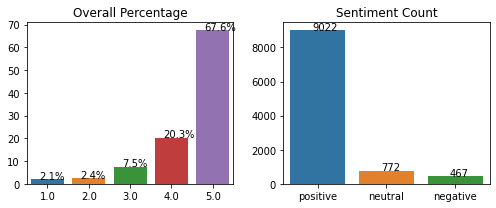

In [6]:
# display overall ranks and sentiment distribution
def plot_distribution():
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    
    # 1. percentage per rate
    labels = df['overall'].unique().tolist()
    percent_list = []
    
    # new list of percentages
    for i in labels:
        pct = (df['overall'].value_counts()[i] / len(df)) * 100
        percent_list.append(round(pct, 1))
    
    graph = sns.barplot(x=labels, y=percent_list, ax=axes[0])
    graph.set_title('Overall Percentage')
    
    percent_list.sort()
    for bar, i in zip(graph.patches, percent_list):
            x = bar.get_x() + bar.get_width()/4
            y = bar.get_height() + 0.1
            graph.text(x, y, s=str(i)+'%')
            
    # 2. sentiment counts
    labels = df['sentiment'].unique().tolist()
    count_list = []
        
    # new list of counts
    for i in labels:
        count_list.append(df['sentiment'].value_counts()[i])
    
    graph = sns.barplot(x=labels, y=count_list, ax=axes[1])
    graph.set_title('Sentiment Count')
    
    for bar, i in zip(graph.patches, count_list):
            x = bar.get_x() + bar.get_width()/2.5
            y = bar.get_height() + 0.1
            graph.text(x, y, s=i)
            
    plt.tight_layout()
    plt.show()
    
plot_distribution()

These charts show that customers are in general very happy about their instruments. Perhaps this is because their purchases are very thoughtful.

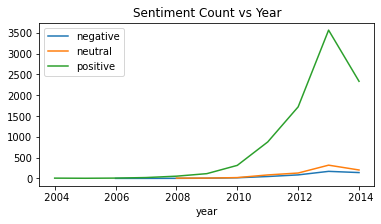

In [7]:
# display sentiment counts throughout time series
def sentiment_count_year():
    # extract and add year column
    review_time = df['reviewTime'].str.split(',', n=1, expand=True)
    df['year'] = review_time[1]
    
    # plot count values per year
    df.groupby(['year', 'sentiment'])['sentiment'].count().unstack().plot(figsize=(6, 3))
    plt.title('Sentiment Count vs Year')
    plt.xlabel('year')
    plt.legend()
    plt.show()
    
sentiment_count_year()

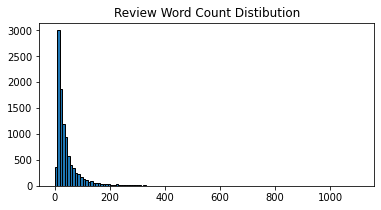

In [8]:
# plot frequency of words in reviews
def review_word_count():
    plt.figure(figsize=(6, 3))
    plt.hist(x=df['reviewText'].str.split().str.len(), bins=120, edgecolor='black')
    plt.title('Review Word Count Distibution')
    plt.show()
    
review_word_count()

**Trigrams**

N-grams are continuous sequences of words or symbols, or tokens in a document. In technical terms, they can be defined as the neighboring sequences of items in a document. We will extract most populars phrases for each sentiment type.

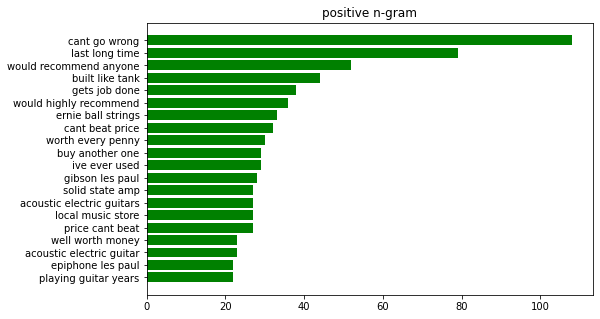

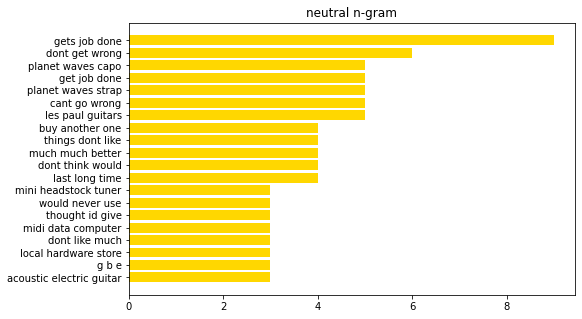

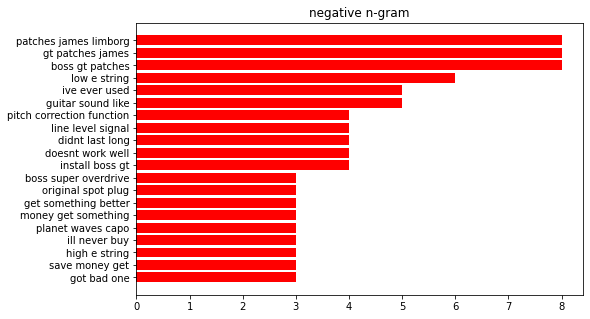

In [9]:
# plot trigrams
# example: https://www.analyticsvidhya.com/blog/2021/09/what-are-n-grams-and-how-to-implement-them-in-python/
def plot_ngram(n=3, sentiment='neutral', color='yellow'):
    # filter out by 'sentiment'
    df_sent = df.query(f"sentiment == '{sentiment}'")
    
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    
    def generate_ngrams(text, n_gram=1):
        token = [token for token in text.lower().split(' ') if token != '' if token not in stop_words]
        n_grams = zip(*[token[i:] for i in range(n_gram)])
        return [' '.join(n_gram) for n_gram in n_grams]
    
    # unigram
    from collections import defaultdict
    
    freq_dict = defaultdict(int)
    for sent in df_sent['reviewText']:
        for word in generate_ngrams(sent, n):
            freq_dict[word] += 1
    df_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    df_sorted.columns = ['phrase', 'frequency']
    df_sorted = df_sorted.head(20)
    
    # plot results
    plt.figure(figsize=(8, 5))
    plt.barh(df_sorted['phrase'], df_sorted['frequency'], color=color)
    plt.gca().invert_yaxis()
    plt.title(sentiment + ' n-gram')
    plt.show()

plot_ngram(sentiment='positive', color='green')
plot_ngram(sentiment='neutral', color='gold')
plot_ngram(sentiment='negative', color='red')

**Word Clouds**

A word cloud is a technique to show which words are the most frequent in the given text and they are similar to bar blots. Word clouds can be particularly helpful to identify the most important themes or topics in a large body of text and to communicate the key ideas or concepts in a visually engaging way. We will generate word clouds for each sentiment.

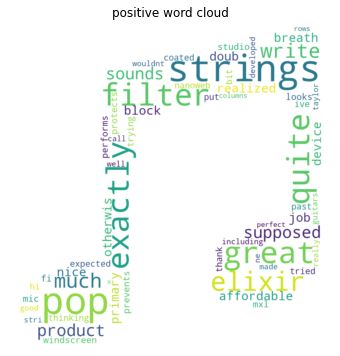

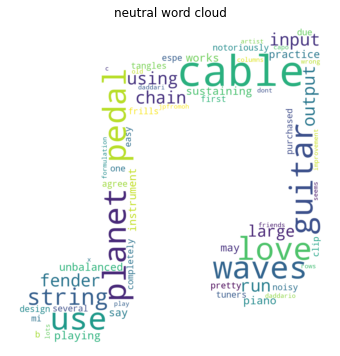

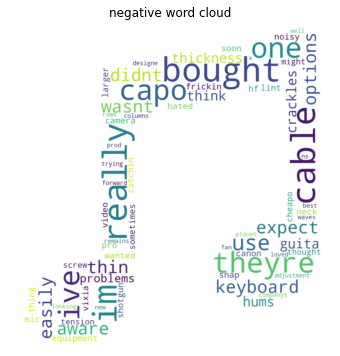

In [10]:
# plot word clouds
def plot_wordcloud(sentiment='positive'):
    import os
    from wordcloud import WordCloud, STOPWORDS
    from numpy import array
    from PIL import Image
    
    # filter out by 'sentiment'
    text = df.query(f"sentiment == '{sentiment}'").loc[:, ['reviewText']]
    
    # set mask from image
    MASK = array(Image.open(os.getcwd() + '\music_note.png'))
    
    # update stop word list
    stop_words = set(STOPWORDS)
    stop_words.update(['positive', 'neutral', 'negative', 'sentiment', 'reviewText'])

    # generate a word cloud
    word_cloud = WordCloud(background_color='white', max_words=600, colormap='viridis', width=2000, height=2000,
                           mask=MASK, stopwords=stop_words).generate(str(text))

    plt.figure(figsize=(6, 6))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title(sentiment + ' word cloud')
    plt.axis('off')
    plt.show()
    
plot_wordcloud(sentiment='positive')
plot_wordcloud(sentiment='neutral')
plot_wordcloud(sentiment='negative')

### 3. Sentiment Analysis

**3a. VADER Sentiment Scoring**

We will perform sentiment analysis using the VADER (Valence Aware Dictionary and sEntiment Reasoner) analyzer. VADER is a lexicon, pretrained and rule-based sentiment analysis tool that is suited for language used in social media and short sentences. It removes stop words and scores each word combining them into a total score. The analyzer returns negative, neutral, positive, and compound scores ranged in [-1, 1]. Scores closer to -1 are considered negative, close to 0 as neutral, and positive are for scores close to 1. We will visualize the VADER results and compare them to the overall ranks.

In [11]:
# apply VADER analyzer
def vader_scoring():
    #nltk.download('vader_lexicon')
    from nltk.sentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # new dataframe from existing
    df_vader = df.copy()
    
    for col in ['neg', 'neu', 'pos', 'compound']:
        df_vader[col] = [analyzer.polarity_scores(x)[col] for x in df_vader['reviewText']]
        
    return df_vader
        
df_vader = vader_scoring()
df_vader.head()

,overall,reviewTime,sentiment,reviewText,year,neg,neu,pos,compound
0,5.0,"02 28, 2014",positive,much write exactly supposed filters pop sounds...,2014,0.092,0.669,0.239,0.4939
1,5.0,"03 16, 2013",positive,product exactly quite affordable realized doub...,2013,0.000,0.739,0.261,0.9359
2,5.0,"08 28, 2013",positive,primary job device block breath would otherwis...,2013,0.102,0.847,0.051,-0.3400
3,5.0,"02 14, 2014",positive,nice windscreen protects mxl mic prevents pops...,2014,0.087,0.595,0.317,0.5859
4,5.0,"02 21, 2014",positive,pop filter great looks performs like studio fi...,2014,0.000,0.680,0.320,0.7650


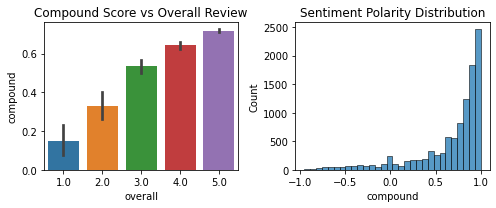

In [12]:
# group by overall reviews and plot compound scores
def plot_compound_scores():
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    sns.barplot(data=df_vader, x='overall', y='compound', hue=None, ax=axes[0])
    sns.histplot(data=df_vader, x='compound', bins=30, ax=axes[1])
    axes[0].set_title('Compound Score vs Overall Review')
    axes[1].set_title('Sentiment Polarity Distribution')
    plt.tight_layout()
    plt.show()
    
plot_compound_scores()

This is exactly what we should expect. Higher and positive polarity scores should be assigned with each higher rank. In terms of score distribution, we can see that most reviews are positive. We will also display VADER results for each component.

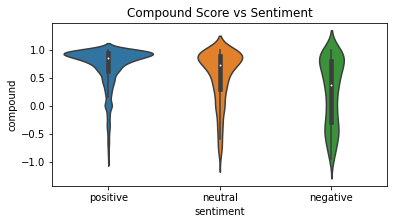

In [13]:
# display violin plots for each sentiment
def violin_plot():
    plt.figure(figsize=(6, 3))
    sns.violinplot(x=df_vader['sentiment'], y=df_vader['compound'])
    plt.title('Compound Score vs Sentiment')
    plt.show()
    
violin_plot() 

The violins clearly display that higher polarity scores are more frequent in positive reviews. The negative violin plot shows more balance in scores.

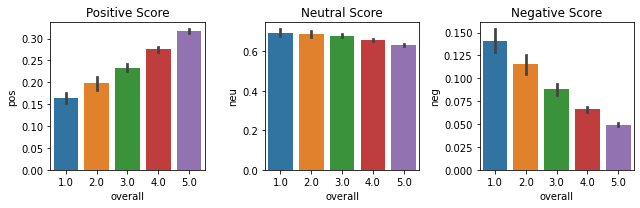

In [14]:
def plot_polarity_scores(df):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    sns.barplot(data=df, x='overall', y='pos', ax=axes[0]).set_title('Positive Score')
    sns.barplot(data=df, x='overall', y='neu', ax=axes[1]).set_title('Neutral Score')
    sns.barplot(data=df, x='overall', y='neg', ax=axes[2]).set_title('Negative Score')
    plt.tight_layout()
    plt.show()
    
plot_polarity_scores(df=df_vader)

Again, we can see the polarity scores for each component are correctly assigned:
* positive ranks are higher and confidence intervals (whiskers on bars) are narrower with each higher star rank,
* neutral reviews are more flatten (with a slight negative slope towards 5 star overalls),
* negative reviews are less frequent with each higher star and at the same the confidence intervals are progressively narrower.

The VADER transformer has a lexical approach and is easy to implement. This also means that it may have trouble recognizing text with misspelling and grammatical mistakes. We will try a more sophisticated model.

**3b. RoBERTa Sentiment Scoring**

This is another pretrained model supported by [Hugging Face](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest) and is a robustly optimized approach of Google's BERT model. Unlike VADER, this transformer is more complex and is able to detect sarcastic reviews. It was trained on tweets. RoBERTa does not compute a compound score like the VADER model. So we compare the three probabilities (negative, neutral, and positive) and the highest one becomes the label of the review.

According to a [section](https://huggingface.co/learn/nlp-course/chapter2/5?fw=pt) on Hugging Face, there is a limit to the lengths of the sequences we can pass the models. Most BERT models handle sequences up to 514, and will crash when asked to process longer reviews. Increasing the token maximum length in pretrained models is impossible and does not make sense. Therefore, we will truncate very long reviews.

In [15]:
# apply RoBERTa model
def roberta_scoring():
    from transformers import AutoTokenizer, RobertaConfig, TFAutoModelForSequenceClassification
    import numpy as np
    from scipy.special import softmax
    from tqdm.notebook import tqdm_notebook
    
    # turn off warnings
    from transformers import logging
    logging.set_verbosity_error()
    
    # load model from Hugging Face Hub
    MODEL = 'cardiffnlp/twitter-roberta-base-sentiment'
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    config = RobertaConfig.from_pretrained(MODEL)
    rob_model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

    # get max length
    max_sequence_length = config.max_position_embeddings
    
    # new dataframe from existing
    df_roberta = df.copy()
    
    # lists for storing scores
    neg_list = []
    neu_list = []
    pos_list = []
    
    # run model and iterate over each row
    for index, row in tqdm_notebook(df_roberta.iterrows(), total=df_roberta.shape[0], mininterval=20, desc='Progress'):
        encoded_input = tokenizer(text=row.reviewText[:max_sequence_length], return_tensors='tf')
        output = rob_model(**encoded_input)
        scores = softmax(output[0][0].numpy())
        neg_list.append(scores[0])
        neu_list.append(scores[1])
        pos_list.append(scores[2])
    
    df_roberta['neg'] = neg_list
    df_roberta['neu'] = neu_list
    df_roberta['pos'] = pos_list
    
    return df_roberta
    
df_roberta = roberta_scoring()
df_roberta.head()

Progress:   0%|          | 0/10261 [00:00<?, ?it/s]

,overall,reviewTime,sentiment,reviewText,year,neg,neu,pos
0,5.0,"02 28, 2014",positive,much write exactly supposed filters pop sounds...,2014,0.023359,0.368564,0.608077
1,5.0,"03 16, 2013",positive,product exactly quite affordable realized doub...,2013,0.013205,0.117627,0.869167
2,5.0,"08 28, 2013",positive,primary job device block breath would otherwis...,2013,0.042467,0.760717,0.196816
3,5.0,"02 14, 2014",positive,nice windscreen protects mxl mic prevents pops...,2014,0.055389,0.632311,0.312300
4,5.0,"02 21, 2014",positive,pop filter great looks performs like studio fi...,2014,0.029726,0.344967,0.625307


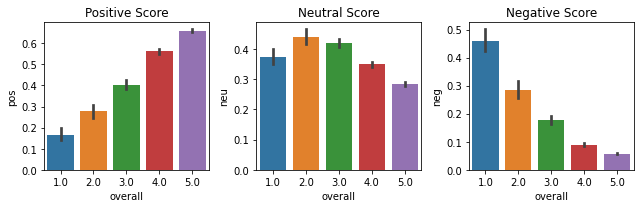

In [16]:
plot_polarity_scores(df=df_roberta)

We can see the patterns repeat as in the VADER analyzer which means that the RoBERTa model performed correctly. This time the slopes are more distinquished in positive and negative scoring. The neutral scores are more dominant for moderate ranks: two and three stars. Comparing to previous distribution, we see this model performed more confidently than VADER.

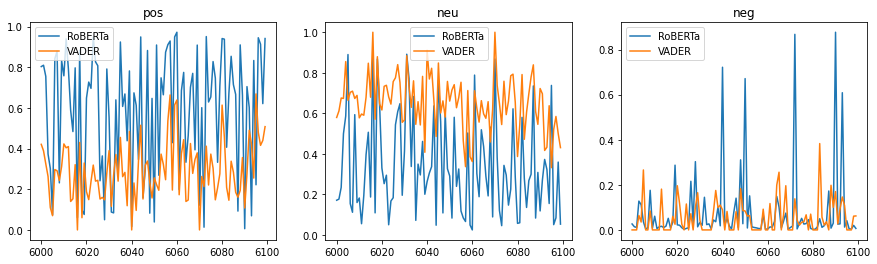

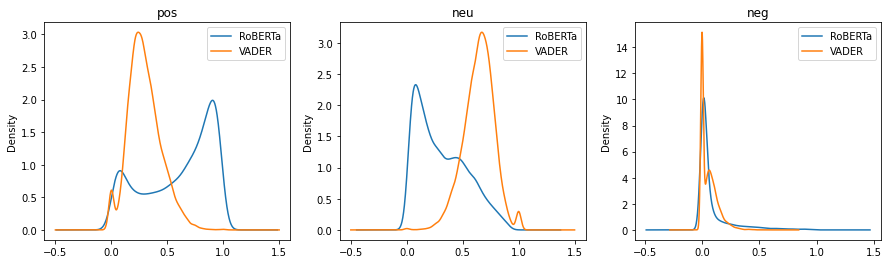

In [17]:
# compare results for both models
def compare_scoring():
    senty_list = ['pos', 'neu', 'neg']
    
    # 1. line plots
    plt.figure(figsize=(15, 4))
    
    for i, col in enumerate(senty_list):   
        plt.subplot(1, 3, i+1)
        plt.plot(df_roberta[col][6000:6100], label='RoBERTa')
        plt.plot(df_vader[col][6000:6100], label='VADER')
        plt.title(col)
        plt.legend()
    plt.show()
    
    # 2. density (distribution) plots
    plt.figure(figsize=(15, 4))
    
    for i, col in enumerate(senty_list):   
        plt.subplot(1, 3, i+1)
        df_roberta[col].plot(kind='density', label='RoBERTa')
        df_vader[col].plot(kind='density', label='VADER')
        plt.title(col)
        plt.legend()
    plt.show()

compare_scoring()

The VADER scoring follows a more normal distribution. In general, the RoBERTa model made predictions in much larger ranges and are shifted higher for the positive scores and lower for neutral. Negative plots have more spikes and higher sentiment intensity. This behavior concludes the VADER analyzer is less confident in terms of scoring.

### 4. Preprocessing and Splitting Data

For the machine learning stage, we will take the variable with user reviews and <code>sentiment</code> column as our target data. Firstly, we must encode categorical labels in the target feature. Secondly, we will convert the raw text (instrument reviews) to a matrix of TF-IDF features. Thirdly, we will fix the high category disproportions with SMOTE technique. Finally, the data will be splitted and applied for building classifiers.

In [18]:
# encode categorical labels - map into integers
def encode_labels():
    from sklearn import preprocessing
    
    # encode labels in column 'sentiment' 
    lab_encod = preprocessing.LabelEncoder() 
    df['sentiment']= lab_encod.fit_transform(df['sentiment']) 
    
    # print counts of unique classes
    return df.groupby(['sentiment'])['sentiment'].count().T
    
encode_labels()

sentiment
0     467
1     772
2    9022
Name: sentiment, dtype: int64

TF-IDF (Term Frequency — Inverse Document Frequency) is a technique that uses the frequency of words to determine how relevant those words are to a given document. It computes a weight to each word which signifies its importance in the document and corpus. In other words, TF-IDF is a measure of originality of a word by comparing the number of times a word appears in a document with the number of documents the word appears in. It is a relatively simple and intuitive approach to weight words commonly used in search engines, summarizing documents, and other tasks related to information retrieval and machine learning domains.

In this case we will take only the top 7000 words from our reviews. We will split them into bigrams (two words) and consider their combined weight.

In [19]:
# apply TF-IDF on reviews
def tfidf_frequency():
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    global X, y
    
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words=None, max_features=7000, ngram_range=(2, 2))
    reviews = df[['reviewText']].reset_index(drop=True)
    
    # TF-IDF feature matrix
    X = tfidf_vectorizer.fit_transform(reviews['reviewText'])
    # target data y
    y = df['sentiment']
    
tfidf_frequency()

We noticed previously high imbalance in our feature target - lots of positive reviews compared to negative and nuetral. In order to fix the class imbalance we will apply SMOTE technique (Synthetic Minority Over-sampling TEchnique). This preprocessing technique randomly increases minority class examples by replicating them (generating new synthetic examples close to the other points). These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

Next, we will split our new resampled dataset into training and testing data with 80:20 ratio and proceed into developing our classifying models.

In [20]:
# fix class imbalance with SMOTE and split data into samples
def apply_smote():
    from imblearn.over_sampling import SMOTE
    from sklearn.model_selection import train_test_split
    
    global X_train, X_test, y_train, y_test
    
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    print('Original dataset counts:')
    print(y.value_counts().T)
    print('\nResampled dataset counts:')
    print(y_resampled.value_counts().T)
    
    # split data (80:20)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)
    
apply_smote()

Original dataset counts:
2    9022
1     772
0     467
Name: sentiment, dtype: int64

Resampled dataset counts:
2    9022
1    9022
0    9022
Name: sentiment, dtype: int64


### 5. Model Training and Evaluating

We will train five different machine learning models and evaluate their performance with accuracy scores.

In [21]:
# run classifiers and evaluate with cross-validation
def test_classifiers():
    from xgboost import XGBClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import SGDClassifier
    from sklearn.naive_bayes import BernoulliNB
    from sklearn.model_selection import cross_val_score
    
    # initialize dict and list of models
    mod_dict = {0: 'XGB', 1: 'RF', 2: 'KNN', 3: 'SGD', 4: 'NB'}
    models = [XGBClassifier(), RandomForestClassifier(), KNeighborsClassifier(), SGDClassifier(), BernoulliNB()]
    
    for i, model in enumerate(models):
        print('{} test accuracy: {:.6f}'.format(mod_dict[i], cross_val_score(model, X, y, cv=10, scoring='accuracy').mean()))
        
test_classifiers()

XGB test accuracy: 0.879446
RF test accuracy: 0.875158
KNN test accuracy: 0.852744
SGD test accuracy: 0.880811
NB test accuracy: 0.803331


The stochastic gradient descent (SGD) algorithm seems to perform the best on this dataset. We will make hyperparameter searching to leverage its performance.

In [22]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()

# grid of hyperparameters for tuning
sgd_hyperpameters = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1], # learning rate
                     'loss': ['log'], # logistic regression
                     'penalty': ['l2'] # ridge regularization
                    }

# perform grid searching (find optimal parameters)
def grid_search(classifier=sgd_clf, grid_params=sgd_hyperpameters):
    from sklearn.model_selection import GridSearchCV

    clf = GridSearchCV(classifier, param_grid=grid_params, cv=5, verbose=2)
    best_model = clf.fit(X_train, y_train)
    
    print('\n===== Best Parameters =====')
    print(best_model.best_estimator_)
    print('Mean accuracy after tuning: {:.6f}'.format(best_model.score(X_test, y_test)))
    
    return best_model.best_estimator_

# get best SGD classifier
best_sgd = grid_search()

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ..................alpha=1e-05, loss=log, penalty=l2; total time=   0.0s
[CV] END ..................alpha=1e-05, loss=log, penalty=l2; total time=   0.0s
[CV] END ..................alpha=1e-05, loss=log, penalty=l2; total time=   0.0s
[CV] END ..................alpha=1e-05, loss=log, penalty=l2; total time=   0.0s
[CV] END ..................alpha=1e-05, loss=log, penalty=l2; total time=   0.0s
[CV] END .................alpha=0.0001, loss=log, penalty=l2; total time=   0.0s
[CV] END .................alpha=0.0001, loss=log, penalty=l2; total time=   0.0s
[CV] END .................alpha=0.0001, loss=log, penalty=l2; total time=   0.0s
[CV] END .................alpha=0.0001, loss=log, penalty=l2; total time=   0.0s
[CV] END .................alpha=0.0001, loss=log, penalty=l2; total time=   0.0s
[CV] END ..................alpha=0.001, loss=log, penalty=l2; total time=   0.0s
[CV] END ..................alpha=0.001, loss=log,

The optimum SGD classifier will be retrained with new hyperparameters. To evaluate the quality of multiclass classifier we will plot a confusion matrix, display a classification report, and generate ROC curves.

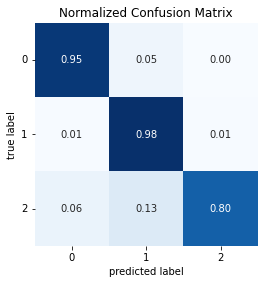

In [23]:
# display normalized confusion maxtrix
def plot_confusion_matrix(classifier=best_sgd):
    from sklearn.metrics import confusion_matrix
    from seaborn import heatmap
    
    # make predictions
    clf = classifier.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
        
    # heatmap properties
    hm_kwargs = dict(cmap='Blues', square=True, annot=True, fmt='.2f', cbar=False)
    
    # plot confusion matrix
    plt.figure(figsize=(4, 5))    
    confu_matrix = confusion_matrix(y_test, y_pred.astype(int), normalize='true')
    heatmap(data=confu_matrix, **hm_kwargs)
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.title('Normalized Confusion Matrix')
    plt.yticks(rotation=0) 
    plt.show()

plot_confusion_matrix()

In [24]:
# display report showing the main classification metrics
def classification_report(classifier=best_sgd):
    from sklearn.metrics import classification_report
    
    # make predictions
    clf = classifier.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    target_names = ['class 0', 'class 1', 'class 2']
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    return pd.DataFrame(report).T.round(4)

classification_report()

,precision,recall,f1-score,support
class 0,0.9339,0.9455,0.9396,1852.000
class 1,0.8392,0.9856,0.9066,1811.000
class 2,0.9887,0.7973,0.8827,1751.000
accuracy,0.9110,0.9110,0.9110,0.911
macro avg,0.9206,0.9095,0.9096,5414.000
weighted avg,0.9199,0.9110,0.9102,5414.000


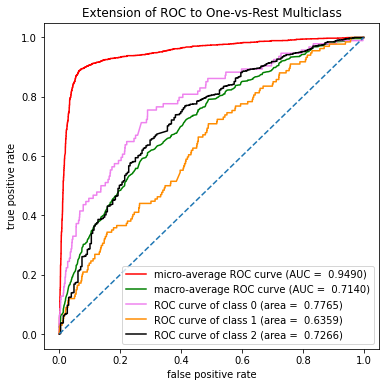

In [25]:
# plot Receiver Operating Characteristic curves for multiclass classifier
# example: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc_curves(classifier=best_sgd):
    from sklearn.preprocessing import label_binarize
    from sklearn.model_selection import train_test_split
    from sklearn.multiclass import OneVsRestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    
    # binarize the target feature
    y_bin = label_binarize(y, classes=[0, 1, 2])
    n_classes = y_bin.shape[1]
    
    # split new data
    X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=0)
    
    # set One-Vs-Rest multiclass strategy
    clf = OneVsRestClassifier(classifier)
    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    
    # compute TPR and FPR
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
        
    # aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    # average it and compute AUC
    mean_tpr /= n_classes
    
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
    
    # plot all ROC curves
    plt.figure(figsize=(6, 6))
    plt.plot(fpr['micro'], tpr['micro'], label='micro-average ROC curve (AUC = {0: 0.4f})'.format(roc_auc['micro']),
             color='red')
    plt.plot(fpr['macro'], tpr['macro'], label='macro-average ROC curve (AUC = {0: 0.4f})'.format(roc_auc['macro']),
             color='green')
    
    colors = ['violet', 'darkorange', 'black']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0} (area = {1: 0.4f})'.format(i, roc_auc[i]))
        
    plt.plot([0,1], [0, 1], linestyle='--')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title('Extension of ROC to One-vs-Rest Multiclass')
    plt.legend(loc='lower right')
    plt.show()
    
plot_roc_curves()

The evaluation results show that neutral reviews (class 1) are the most trickiest to predict. Overall, the model's predictions are highly accurate.

### 6. Conclusions

This project aims to present the basic concepts of sentiment analysis and NLP. We introduced two different scoring approaches on user reviews on Amazon on musical instruments and performed a multiclass classification task. To make more use of the text, we previously needed to perform text cleaning and normalizing. This was done by removing stop words and applying different regular expression operations.

Sentiment analysis was completed by using the built-in VADER model in the NLTK package and with transfer learning on Hugging Face platform. Both algorithms performed as excepted but the pretrained model - RoBERTa, performed with higher confidence.

The last stage of this notebook was to built a classifier and identify the emotions behind on customer reviews. To improve the learning process we implemented SMOTE technique to fix label imbalance. The best performance was assigned to the stochastic gradient descent model with overall 0.9110 accuracy. We proved that sentiment classification is possible on this dataset of instrument reviews.

Sentiment analysis shows to be important and beneficial for business usage. Regularly performed on text-based information can assist organizations with checking item opinion in customer feedback and comprehend customer needs. Customer sentiment can further develop customer devotion and maintenance by further developing help results and upgrading the customer experience.

**References:**
* Chris Albon, 2018, *Machine Learning with Python Cookbook: Practical Solutions from Preprocessing to Deep Learning, 1st Edition* 
* Pallavi Tilloo, Raga Sudha Gottimukkala, Sreeja Mamidala, 2021, *Sentiment Analysis for Amazon Musical Instruments User Reviews* [Full Text](https://www.researchgate.net/publication/349251195_Sentiment_Analysis_for_Amazon_Musical_Instruments_User_Reviews)